## Objective

We will now look at what the finetuned InceptionV3 model is learning.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Standard Imports

In [0]:
#!pip install innvestigate

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import sys
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Run this if you are using google colab
sys.path.append('/content/drive/My Drive/')

from src.utils import *
from src.visualisation import *
from src.model import make_finetuned_inceptv3

In [0]:
!unzip -q 'drive/My Drive/cell-images-for-detecting-malaria.zip'

# Create 'Combined' directory and copy all the png images over
# Note that the name 'Combined' must match that in the directory of the generator

!mkdir Combined 
!cp -a cell_images/cell_images/Parasitized/. Combined
!cp -a cell_images/cell_images/Uninfected/. Combined

## Reobtain the data and generators

In [0]:
# Read from the csv 
df_train = pd.read_csv('drive/My Drive/data/malaria_train_combined.csv')
df_val = pd.read_csv('drive/My Drive/data/malaria_val_combined.csv')
df_test = pd.read_csv('drive/My Drive/data/malaria_test_combined.csv')

df_train['labels'] = df_train['labels'].astype(str)
df_val['labels'] = df_val['labels'].astype(str)
df_test['labels'] = df_test['labels'].astype(str)

In [0]:
from keras.applications.inception_v3 import preprocess_input

# Create generators manually
train_datagen = ImageDataGenerator(
     preprocessing_function=lambda x: preprocess_input(x),
     shear_range=0.2,
     zoom_range=0.2,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     horizontal_flip=True)
  
val_datagen = ImageDataGenerator(preprocessing_function=lambda x: preprocess_input(x))

In [10]:
# Get the generators
train_gen, valid_gen, test_gen = fit_into_generators(df_train,df_val,df_test,train_datagen, val_datagen,batch_size=32,shape=(299,299))

Found 19291 validated image filenames belonging to 2 classes.
Found 6199 validated image filenames belonging to 2 classes.
Found 2068 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="train_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="val_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
from keras import layers, optimizers

In [12]:
# Reload finetuned-inceptv3 model
model = make_finetuned_inceptv3()

model.load_weights('/content/drive/My Drive/weights/finetuned_inceptv3_weights_for_predicting_malaria.h5')
model.compile(optimizers.Adam(0.01), loss = "categorical_crossentropy", metrics=['accuracy'])

87916544/87910968 [==============================] - 7s 0us/step


In [13]:
model.evaluate_generator(test_gen)

[0.14086293505515535, 0.9453578334251271]

## Get Confusion Matrix

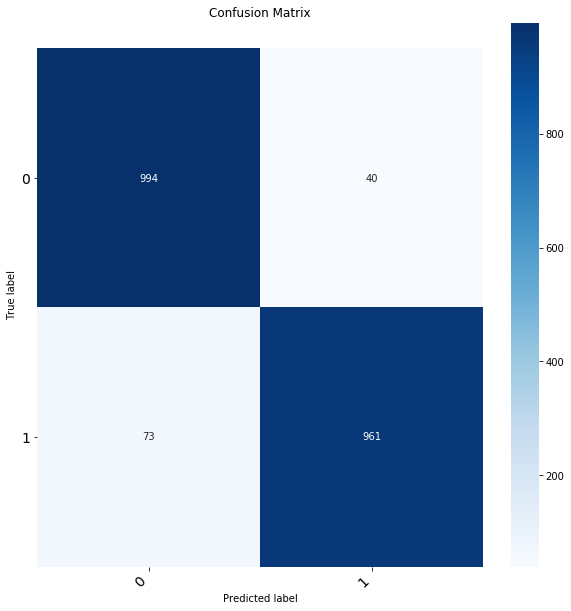

In [14]:
tp,tn,fp,fn = get_confusion_matrix(model,test_gen)

- 40 False Positives and 73 False negatives

## Visualisation of 'Explainability' of finetuned inceptv3 model 

In [0]:
import imp
import innvestigate
import innvestigate.utils as iutils

imgnetutils = imp.load_source("utils_imagenet", "/content/drive/My Drive/src/utils_imagenet.py")

In [0]:
# Define methods
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
    # Function
    ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"),
    
    ("smoothgrad",            {"postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"),

    ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat")
]

In [0]:
from keras import Model

# This is to remove 'model' in the layer for innvestigate to work
x = model.layers[0].layers[-1].get_output_at(0)

for layer in model.layers[1:]:
  x = layer(x)
model_new = Model(inputs=model.layers[0].inputs, outputs=x)

In [0]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model_new)

# Create analyzers.
analyzers = []
for method in methods:
  analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                          model_wo_softmax, # model without softmax output
                                          **method[1])      # optional analysis parameters
  analyzers.append(analyzer)

In [0]:
analyzer_names = ['Gradient', 'Smooth Gradient', 'LRP Preset A Flat']

### True positive samples 

In [22]:
# 4 random true positive samples
sample_indices = [np.random.choice(len(tp[0])) for i in range(4)]
print('The sample indices for true positives are {}'.format(sample_indices))


The sample indices for true positives are [501, 328, 324, 281]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


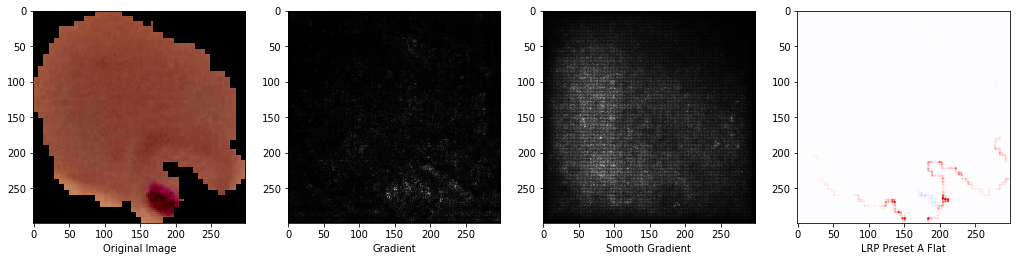

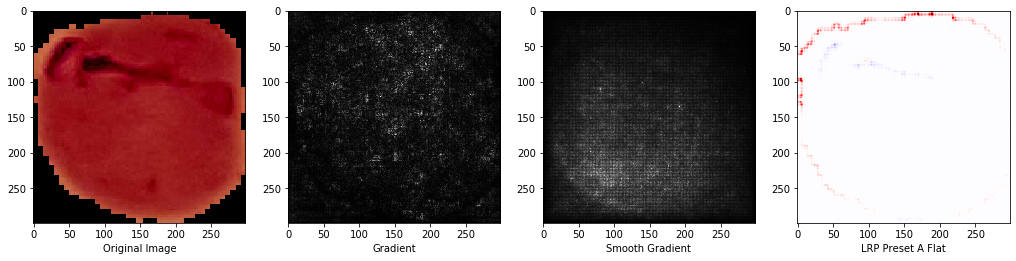

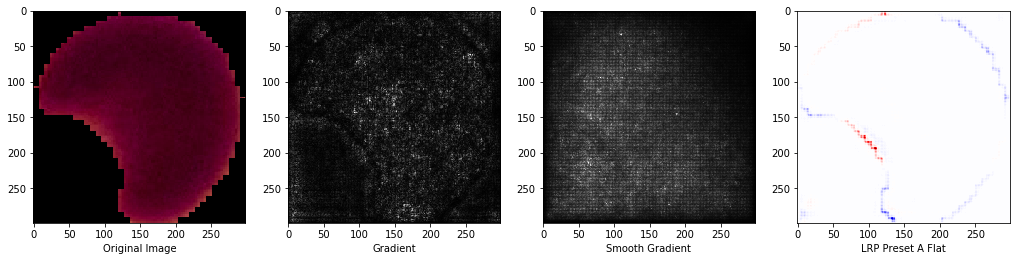

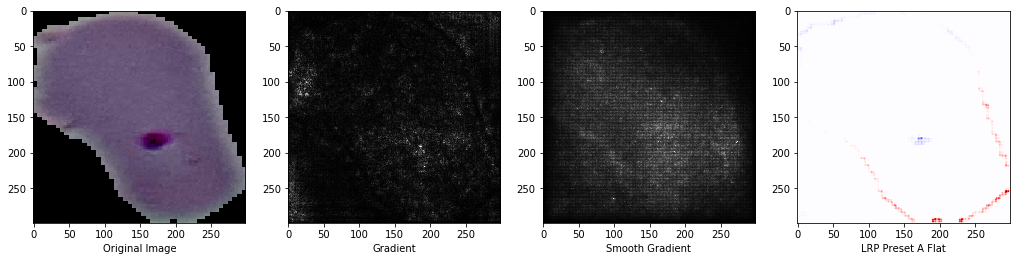

In [23]:
for image_index in sample_indices:
  show_explanation(tp[:,image_index,:,:,:],analyzers,analyzer_names,methods)

For all 4 true positive samples, the model seems to focus on the boundaries near to the parasitized region, indicated by the red boundary ,lines in LRP reset A Flat. However, for samples 1 and 4, the model seems to associate the purple blobs with 'Non-Parasitized', by being more confident towards the negative class in those areas (blue).  

### True Negative Samples

In [26]:
# 4 random true negative samples
sample_indices = [np.random.choice(len(tn[0])) for i in range(4)]
print('The sample indices for true negatives are {}'.format(sample_indices))

The sample indices for true negatives are [868, 116, 77, 660]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


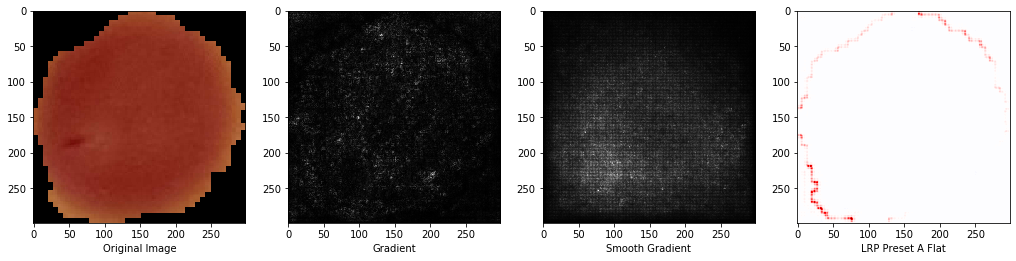

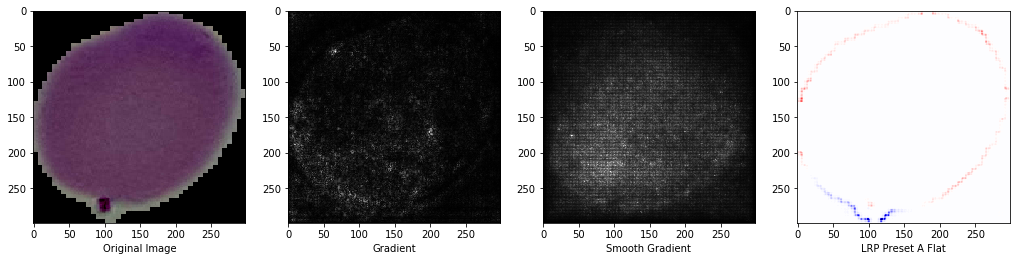

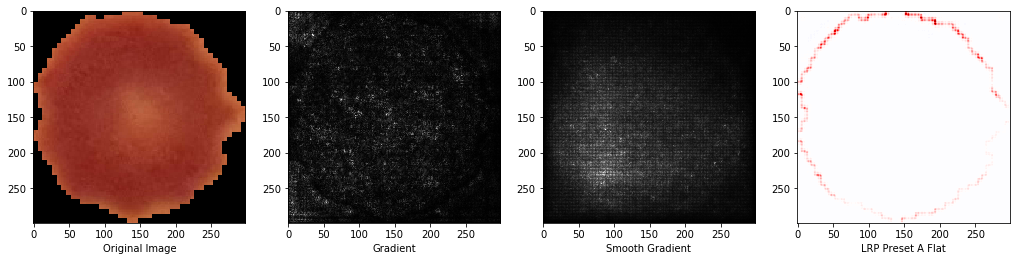

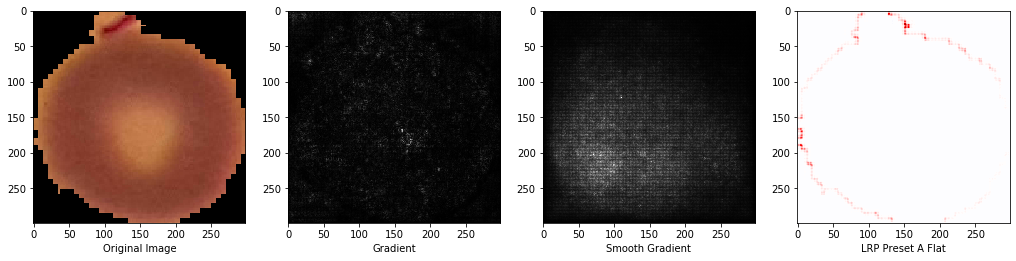

In [27]:
for image_index in sample_indices:
  show_explanation(tn[:,image_index,:,:,:],analyzers,analyzer_names,methods)

Similar to the baseline model, the finetuned inceptionv3 'checks' the majority of the boundary to predict the case of 'Unparasitized'.

### False Positive

In [28]:
# 4 random false positive samples
sample_indices = [np.random.choice(len(fp[0])) for i in range(4)]
print('The sample indices for false positives are {}'.format(sample_indices))

The sample indices for false positives are [34, 2, 21, 31]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


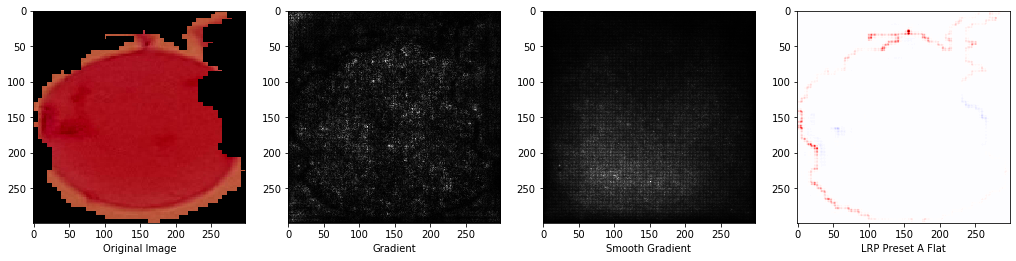

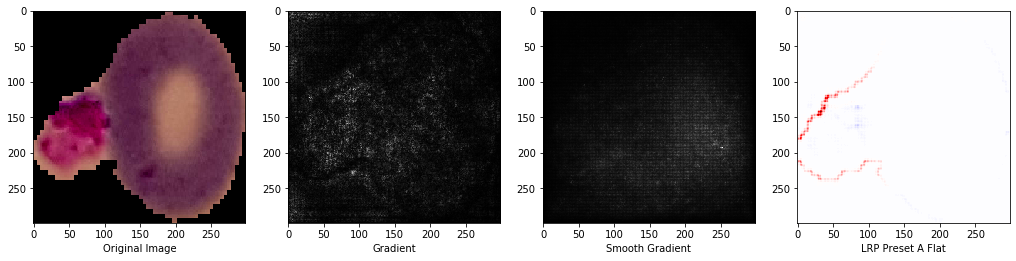

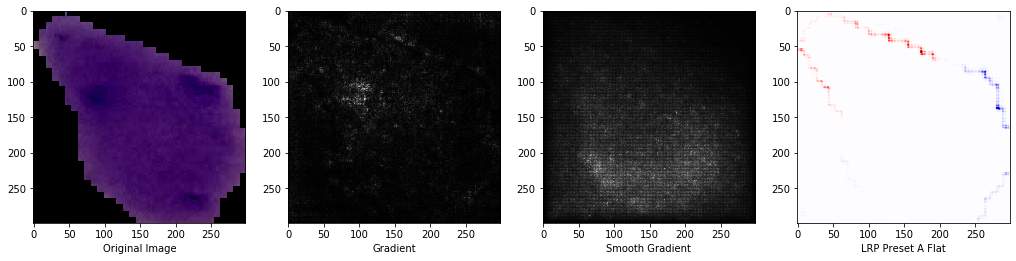

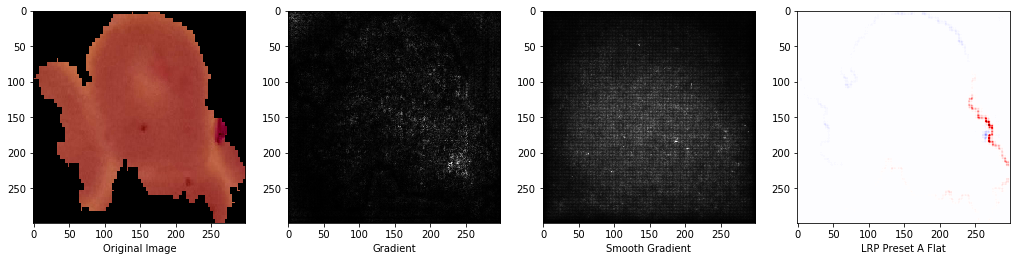

In [29]:
for image_index in sample_indices:
  show_explanation(fp[:,image_index,:,:,:],analyzers,analyzer_names,methods)

For the false positives, the model seems to be similarly confused by boundaries near the parts that might look indicative of 'Parasitized' from a human perspective ( Dark regions in the preprocessed images ). 

### False Negatives

In [30]:
# 4 random false negative samples
sample_indices = [np.random.choice(len(fn[0])) for i in range(4)]
print('The sample indices for false negatives are {}'.format(sample_indices))


The sample indices for false negatives are [48, 17, 7, 50]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


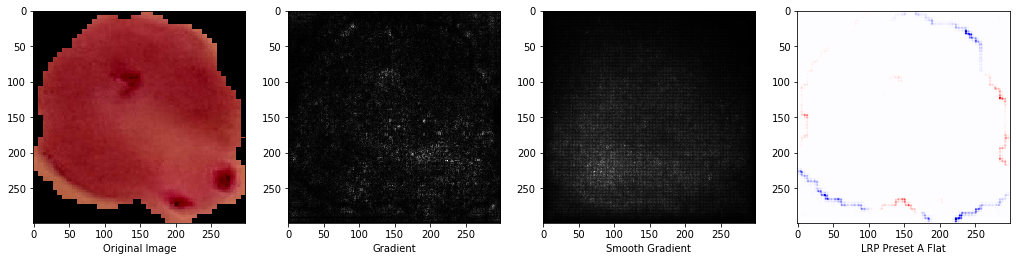

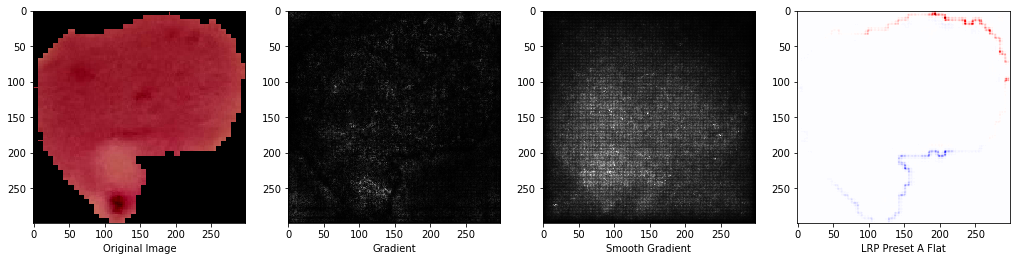

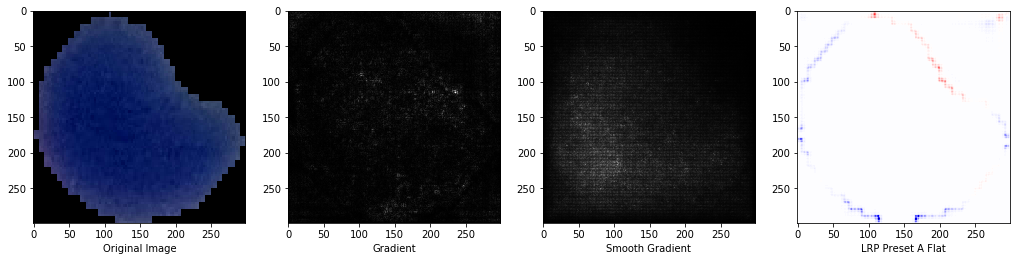

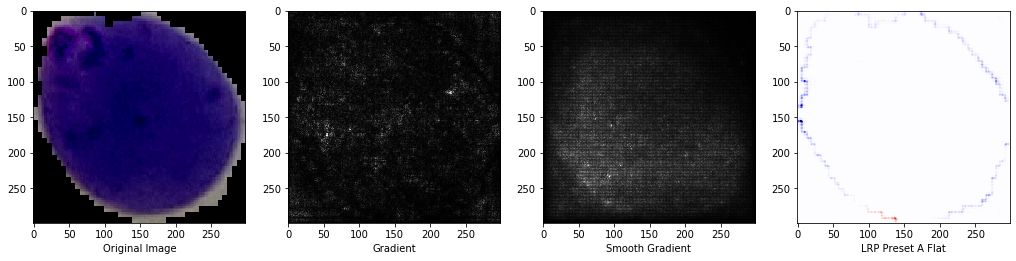

In [31]:
for image_index in sample_indices:
  show_explanation(fn[:,image_index,:,:,:],analyzers,analyzer_names,methods)

Because of some parts in the boundaries, the model is predicting 'Unparasitized' when it should be otherwise. A point of optimism here is that it is somehow certain towards the correct prediction by looking at the boundaries near the right parts. (Blue points of the LRP Preset A Flat map)